In [1]:
import openmc
import matplotlib.pyplot as plt
import matplotlib.figure
import numpy as np

In [2]:

def integrateOverAngles(leakDF):
    leakOut = leakDF.loc[leakDF["mesh 1"]["surf"] == "x-max out"]

    energyLow_series = leakOut["energy low [eV]"].loc[leakDF["mesh 1"]["y"] == 1]
    energyLow_vals = [energyLow_series[index] for index in energyLow_series.index]
    scatter_no_angle = []
    energy = []
    for energyLow_val in energyLow_vals:
        angularDistThisEnergy = leakOut.loc[leakOut["energy low [eV]"] == energyLow_val]
        energyHigh_val = list(angularDistThisEnergy["energy high [eV]"])[0]
        if energyLow_val <= 1.0 and energyHigh_val >= 1.0: continue
        scatter_no_angle.append(np.trapz(list(angularDistThisEnergy["mean"])))
        energy.append((energyLow_val+energyHigh_val)*0.5)
    return energy, scatter_no_angle

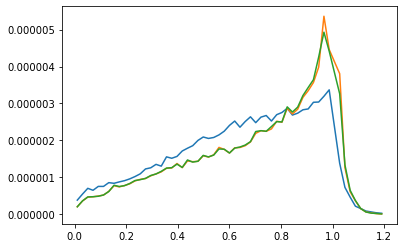

In [35]:
runs = ['400 No Sab',
        '400 True',
        '400 Wrong Dos 800',      # Use 800K phonon DOS for 400K
       ]
names = [string.replace(' ','-') for string in runs]

#filterPairs = [[10,10]],[20,20],[40,40],[60,60],[80,80],[120,120],[150,150],[200,200],[250,250]]
# filterPair = [10,10]
filterPair = [60,60]
# filterPair = [120,120]
particles = 5e7
batches = 10

largeWidth = 1e-5

diff_noSAB_True     = []
diff_True_WrongSAB  = []
diff_noSAB_WrongSAB = []

leakDF_vec = []
for name in names:
    numEFilter,numSpaceFilter = filterPair

    runName = 'Filters__E'+str(numEFilter)+'_Space'+str(numSpaceFilter)
    pathName = 'b'+str(int(batches))+'_p'+('%.0e'%particles).replace('+0','')+'_'+name.replace('-','_')

    sp = openmc.StatePoint('Results/'+runName+'/'+pathName+'/statepoint.'+str(batches)+'.h5')
    leakDF  = sp.get_tally(name='thermal leakage').get_pandas_dataframe()
    leakDF_vec.append(leakDF)




energy,scatter_no_angle = integrateOverAngles(leakDF_vec[0])
plt.plot(energy,scatter_no_angle)
energy,scatter_no_angle = integrateOverAngles(leakDF_vec[1])
plt.plot(energy,scatter_no_angle)
energy,scatter_no_angle = integrateOverAngles(leakDF_vec[2])
plt.plot(energy,scatter_no_angle)



In [40]:
def integrateOverEnergy(leakDF):
    leakOut = leakDF.loc[leakDF["mesh 1"]["surf"] == "x-max out"]
    yVals = list(dict.fromkeys(list(leakOut["mesh 1"]["y"])))

    spatialVec = []
    tallyVec = []
    for yVal in yVals:
        if yVal == int(len(yVals)*0.5): continue
        y1_series = leakOut.loc[leakOut["mesh 1"]["y"] == yVal]
        eLow = list(y1_series["energy low [eV]"])
        eHigh = list(y1_series["energy high [eV]"])
        eMid = [0.5*(eLow[i]+eHigh[i]) for i in range(len(eLow))]
        tallyVec.append(np.trapz(list(y1_series["mean"]),x=eMid))
    return tallyVec

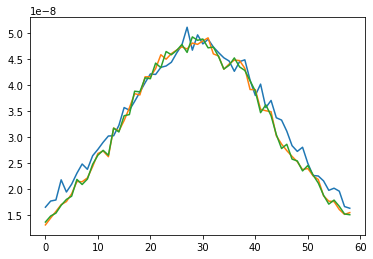

In [42]:
tallyVec = integrateOverEnergy(leakDF_vec[0])
plt.plot(tallyVec)
tallyVec = integrateOverEnergy(leakDF_vec[1])
plt.plot(tallyVec)
tallyVec = integrateOverEnergy(leakDF_vec[2])
plt.plot(tallyVec)


In [29]:
leakDF

mesh 1                energy low [eV] energy high [eV] nuclide    score  \
         x   y       surf                                                     
0        1   1  x-min out        0.00e+00         1.33e-01   total  current   
1        1   1  x-min out        1.33e-01         2.67e-01   total  current   
2        1   1  x-min out        2.67e-01         4.00e-01   total  current   
3        1   1  x-min out        4.00e-01         5.33e-01   total  current   
4        1   1  x-min out        5.33e-01         6.67e-01   total  current   
..     ...  ..        ...             ...              ...     ...      ...   
715      1  10   y-max in        5.33e-01         6.67e-01   total  current   
716      1  10   y-max in        6.67e-01         8.00e-01   total  current   
717      1  10   y-max in        8.00e-01         9.33e-01   total  current   
718      1  10   y-max in        9.33e-01         1.07e+00   total  current   
719      1  10   y-max in        1.07e+00         1.20e+00   total  current   

        mean std. dev.  
                        
0   1.16e-07  9.80e-09  
1   3.20e-08  9.04e-09  
2   8.00e-09  5.33e-09  
3   0.00e+00  0.00e+00  
4   4.00e-09  2.67e-09  
..       ...       ...  
715 0.00e+00  0.00e+00  
716 0.00e+00  0.00e+00  
717 0.00e+00  0.00e+00  
718 0.00e+00  0.00e+00  
719 0.00e+00  0.00e+00  

[720 rows x 9 columns]

In [30]:
energyLow_vals

18    0.000000
19    0.133333
20    0.266667
21    0.400000
22    0.533333
23    0.666667
24    0.800000
25    0.933333
26    1.066667
Name: energy low [eV], dtype: float64

In [2]:
def getArray(leakDF):
    leakOut = leakDF.loc[leakDF["mesh 1"]["surf"] == "x-max out"]

    firstEntry = leakOut.loc[leakOut["mesh 1"]["x"] == 1].loc[leakOut["mesh 1"]["y"] == 1]
    EVals   = list(firstEntry["energy low [eV]"]) + [list(firstEntry["energy high [eV]"])[-1]]
    eMidVec = [(EVals[i]+EVals[i+1])*0.5 for i in range(len(EVals)-1)]

    array = np.zeros((len(eMidVec),max(list(leakOut["mesh 1"]["y"]))))
    for i,eMid in enumerate(eMidVec):
        E_specific = leakOut.loc[leakOut["energy low [eV]"] < eMid]\
                            .loc[leakOut["energy high [eV]"] > eMid]
        if list(E_specific["energy low [eV]"])[0] <= 1.0 and \
           list(E_specific["energy high [eV]"])[0] >= 1.0: continue
        array[i] = E_specific["mean"]
    return array,eMidVec

In [3]:
def plotArray(array,vmax=None):
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    if vmax:
        plt.imshow(array,cmap='hot',extent=[-1,1,-1,1],vmin=0,vmax=vmax)
    else:
        plt.imshow(array,cmap='hot',extent=[-1,1,-1,1])
    plt.ylabel('Energy [eV]')
    plt.xlabel('Space [normalized]')
    desiredEPoints = np.linspace(0.0,1.2,13)
    desiredEPoints_shifted = [2*val/max(desiredEPoints) - 1.0 for val in desiredEPoints]
    desiredEPoints = ['%.1f'%val for val in desiredEPoints]
    ax.set_yticks(desiredEPoints_shifted);
    ax.set_yticklabels(desiredEPoints[::-1]);
    

In [ ]:
runs = ['400 No Sab',
        '400 True',
        '400 Wrong Dos 800',      # Use 800K phonon DOS for 400K
       ]
names = [string.replace(' ','-') for string in runs]

#filterPairs = [[10,10]],[20,20],[40,40],[60,60],[80,80],[120,120],[150,150],[200,200],[250,250]]
filterPairs = [[60,60]]
particles = 5e7
batches = 10

largeWidth = 1e-5

diff_noSAB_True     = []
diff_True_WrongSAB  = []
diff_noSAB_WrongSAB = []

for filterPair in filterPairs:
    leakDF_vec = []
    for name in names:
        numEFilter,numSpaceFilter = filterPair

        runName = 'Filters__E'+str(numEFilter)+'_Space'+str(numSpaceFilter)
        pathName = 'b'+str(int(batches))+'_p'+('%.0e'%particles).replace('+0','')+'_'+name.replace('-','_')

        sp = openmc.StatePoint('Results/'+runName+'/'+pathName+'/statepoint.'+str(batches)+'.h5')
        leakDF  = sp.get_tally(name='thermal leakage').get_pandas_dataframe()
        leakDF_vec.append(leakDF)
        
    leakDF0  = leakDF_vec[0] # No S(a,b)
    leakDF1  = leakDF_vec[1] # True S(a,b))
    leakDF2  = leakDF_vec[2] # Wrong S(a,b)

    array0,Evals0 = getArray(leakDF0)
    array1,Evals1 = getArray(leakDF1)
    array2,Evals2 = getArray(leakDF2)
    
    
    error12 = np.divide(abs(array1-array2), array1, # This will only divide when
                        out=np.zeros_like(array1),  # value in array1 != 0
                        where=array1!=0)            # # This is giving rel. error
    error01 = np.divide(abs(array0-array1), array0, # This will only divide when
                        out=np.zeros_like(array0),  # value in array1 != 0
                        where=array0!=0)            # # This is giving rel. error
    error02 = np.divide(abs(array0-array2), array0, # This will only divide when
                        out=np.zeros_like(array1),  # value in array1 != 0
                        where=array0!=0)            # # This is giving rel. error


    plotArray(array0)
    plt.title('No S(a,b) [400K]')

    plotArray(array1)
    plt.title('True S(a,b) [400K]')

    plotArray(array2)
    plt.title('Wrong S(a,b) [800K instead of 400K]')
    
    plotArray(error12)
    plt.title('True S(a,b) vs. Wrong S(a,b)')
    
    plotArray(error01)
    plt.title('No S(a,b) vs. True S(a,b)')
    
    plotArray(error02)
    plt.title('No S(a,b) vs Wrong S(a,b)')


In [ ]:
runs = ['400 No Sab',
        '400 True',
        '400 Wrong Dos 800',      # Use 800K phonon DOS for 400K
       ]
names = [string.replace(' ','-') for string in runs]


batchesVec = [5,10,20]


filterPair = [50,70]

particles = 1e7
#batches = 10

largeWidth = 1e-5

diff_noSAB_True     = []
diff_True_WrongSAB  = []
diff_noSAB_WrongSAB = []

for batches in batchesVec:
    leakDF_vec = []
    for name in names:
        numEFilter,numSpaceFilter = filterPair

        runName = 'Filters__E'+str(numEFilter)+'_Space'+str(numSpaceFilter)
        pathName = 'b'+str(int(batches))+'_p'+('%.0e'%particles).replace('+0','')+'_'+name.replace('-','_')

        sp = openmc.StatePoint('Results/'+runName+'/'+pathName+'/statepoint.'+str(batches)+'.h5')
        leakDF  = sp.get_tally(name='thermal leakage').get_pandas_dataframe()
        leakDF_vec.append(leakDF)
        
    leakDF0  = leakDF_vec[0]
    leakDF1  = leakDF_vec[1]
    leakDF2  = leakDF_vec[2]

    array0,Evals0 = getArray(leakDF0)
    array1,Evals1 = getArray(leakDF1)
    array2,Evals2 = getArray(leakDF2)

    # plotArray(array0)
    # plotArray(array1)
    # plotArray(array2)
    

    error12 = np.divide(abs(array1-array2), array1, # This will only divide when
                        out=np.zeros_like(array1),  # value in array1 != 0
                        where=array1!=0)            # # This is giving rel. error
    error01 = np.divide(abs(array0-array1), array0, # This will only divide when
                        out=np.zeros_like(array0),  # value in array1 != 0
                        where=array0!=0)            # # This is giving rel. error
    error02 = np.divide(abs(array0-array2), array0, # This will only divide when
                        out=np.zeros_like(array1),  # value in array1 != 0
                        where=array0!=0)            # # This is giving rel. error

    integratedError12 = np.trapz(np.trapz(error12,x=np.linspace(0,largeWidth,numSpaceFilter)),x=Evals1)
    integratedError01 = np.trapz(np.trapz(error01,x=np.linspace(0,largeWidth,numSpaceFilter)),x=Evals1)
    integratedError02 = np.trapz(np.trapz(error02,x=np.linspace(0,largeWidth,numSpaceFilter)),x=Evals1)
    diff_True_WrongSAB.append(integratedError12)
    diff_noSAB_True.append(integratedError01)
    diff_noSAB_WrongSAB.append(integratedError02)

In [ ]:
plt.plot(batchesVec,diff_noSAB_True,'o-')
plt.plot(batchesVec,diff_noSAB_WrongSAB,'o-')
plt.plot(batchesVec,diff_True_WrongSAB,'o-')
plt.yscale('log')
plt.xlabel('Num Batches')

In [ ]:
runs = ['400 No Sab',
        '400 True',
        '400 Wrong Dos 800',      # Use 800K phonon DOS for 400K
       ]
names = [string.replace(' ','-') for string in runs]

filterPairs = [[10,10],[20,20],[40,40],[60,60],[80,80],[120,120],[150,150],[200,200],[250,250]]
particles = 5e7
batches = 10

largeWidth = 1e-5

diff_noSAB_True     = []
diff_True_WrongSAB  = []
diff_noSAB_WrongSAB = []

for filterPair in filterPairs:
    leakDF_vec = []
    for name in names:
        numEFilter,numSpaceFilter = filterPair

        runName = 'Filters__E'+str(numEFilter)+'_Space'+str(numSpaceFilter)
        pathName = 'b'+str(int(batches))+'_p'+('%.0e'%particles).replace('+0','')+'_'+name.replace('-','_')

        sp = openmc.StatePoint('Results/'+runName+'/'+pathName+'/statepoint.'+str(batches)+'.h5')
        leakDF  = sp.get_tally(name='thermal leakage').get_pandas_dataframe()
        leakDF_vec.append(leakDF)
        
    leakDF0  = leakDF_vec[0]
    leakDF1  = leakDF_vec[1]
    leakDF2  = leakDF_vec[2]

    array0,Evals0 = getArray(leakDF0)
    array1,Evals1 = getArray(leakDF1)
    array2,Evals2 = getArray(leakDF2)

    error12 = np.divide(abs(array1-array2), array1, # This will only divide when
                        out=np.zeros_like(array1),  # value in array1 != 0
                        where=array1!=0)            # # This is giving rel. error
    error01 = np.divide(abs(array0-array1), array0, # This will only divide when
                        out=np.zeros_like(array0),  # value in array1 != 0
                        where=array0!=0)            # # This is giving rel. error
    error02 = np.divide(abs(array0-array2), array0, # This will only divide when
                        out=np.zeros_like(array1),  # value in array1 != 0
                        where=array0!=0)            # # This is giving rel. error

    integratedError12 = np.trapz(np.trapz(error12,x=np.linspace(0,largeWidth,numSpaceFilter)),x=Evals1)
    integratedError01 = np.trapz(np.trapz(error01,x=np.linspace(0,largeWidth,numSpaceFilter)),x=Evals1)
    integratedError02 = np.trapz(np.trapz(error02,x=np.linspace(0,largeWidth,numSpaceFilter)),x=Evals1)
    diff_True_WrongSAB.append(integratedError12)
    diff_noSAB_True.append(integratedError01)
    diff_noSAB_WrongSAB.append(integratedError02)

In [ ]:
plt.plot([val[0] for val in filterPairs],diff_noSAB_True,'o-')
plt.plot([val[0] for val in filterPairs],diff_noSAB_WrongSAB,'o-')
plt.plot([val[0] for val in filterPairs],diff_True_WrongSAB,'o-')
# plt.yscale('log')
plt.xlabel('Num Energy&Spatial Filters')

In [4]:
def getArray2(leakDF):
    leakOut = leakDF.loc[leakDF["mesh 1"]["surf"] == "x-max out"]

    firstEntry = leakOut.loc[leakOut["mesh 1"]["x"] == 1].loc[leakOut["mesh 1"]["y"] == 1]
    EVals   = list(firstEntry["energy low [eV]"]) + [list(firstEntry["energy high [eV]"])[-1]]
    eMidVec = [(EVals[i]+EVals[i+1])*0.5 for i in range(len(EVals)-1)]

    array  = np.zeros((len(eMidVec),max(list(leakOut["mesh 1"]["y"]))))
    stddev = np.zeros((len(eMidVec),max(list(leakOut["mesh 1"]["y"]))))
    for i,eMid in enumerate(eMidVec):
        E_specific = leakOut.loc[leakOut["energy low [eV]"] < eMid]\
                            .loc[leakOut["energy high [eV]"] > eMid]
        if list(E_specific["energy low [eV]"])[0] <= 1.0 and \
           list(E_specific["energy high [eV]"])[0] >= 1.0: continue
        array[i]  = E_specific["mean"]
        stddev[i] = E_specific["std. dev."]
    return array,eMidVec,stddev

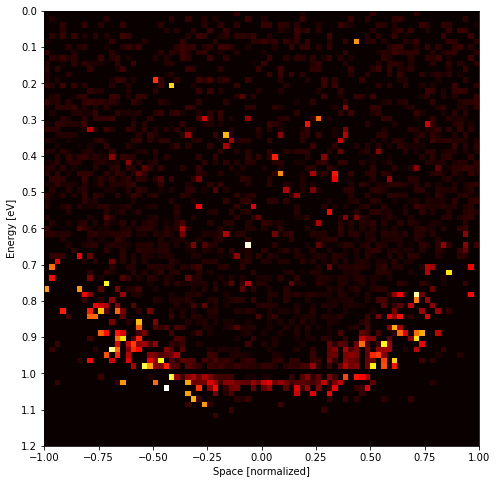

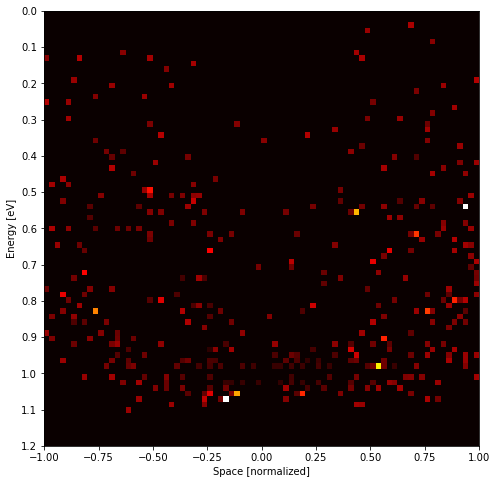

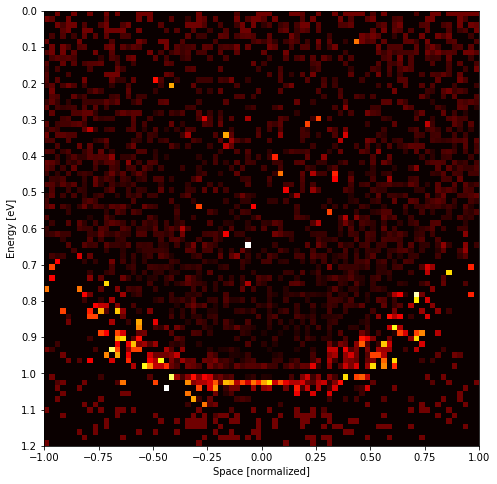

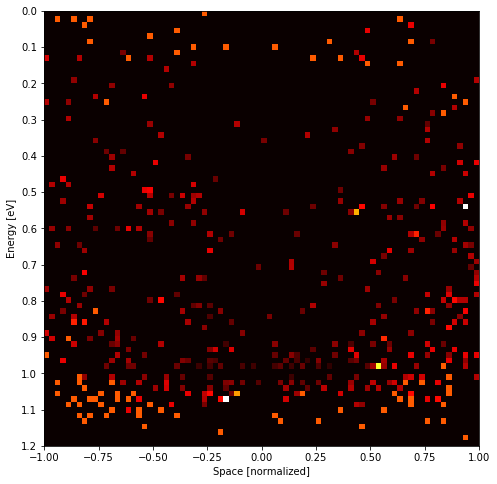

In [22]:
runs = ['400 No Sab',
        '400 True',
        '400 Wrong Dos 800',      # Use 800K phonon DOS for 400K
       ]
names = [string.replace(' ','-') for string in runs]

#filterPairs = [[10,10]],[20,20],[40,40],[60,60],[80,80],[120,120],[150,150],[200,200],[250,250]]
filterPair = [80,80]
particles = 5e7
batches = 10

largeWidth = 1e-5

diff_noSAB_True     = []
diff_True_WrongSAB  = []
diff_noSAB_WrongSAB = []

leakDF_vec = []

for name in names:
    numEFilter,numSpaceFilter = filterPair

    runName = 'Filters__E'+str(numEFilter)+'_Space'+str(numSpaceFilter)
    pathName = 'b'+str(int(batches))+'_p'+('%.0e'%particles).replace('+0','')+'_'+name.replace('-','_')

    sp = openmc.StatePoint('Results/'+runName+'/'+pathName+'/statepoint.'+str(batches)+'.h5')
    leakDF  = sp.get_tally(name='thermal leakage').get_pandas_dataframe()
    leakDF_vec.append(leakDF)

leakDF_NoSab  = leakDF_vec[0] # No S(a,b)
leakDF_True   = leakDF_vec[1] # True S(a,b))
leakDF_Wrong  = leakDF_vec[2] # Wrong S(a,b)

array_NoSab,Evals_NoSab,stddev_NoSab = getArray2(leakDF_NoSab)
array_True ,Evals_True ,stddev_True  = getArray2(leakDF_True )
array_Wrong,Evals_Wrong,stddev_Wrong = getArray2(leakDF_Wrong)


difference_NoSab_True = np.divide(abs(array_NoSab-array_True), array_NoSab, # This will only divide when
                                  out   = np.zeros_like(array_NoSab),       # value in array1 != 0
                                  where = array_NoSab!=0)                   # # This is giving rel. error

difference_True_Wrong = np.divide(abs(array_True-array_Wrong), array_True, # This will only divide when
                                  out   = np.zeros_like(array_True),       # value in array1 != 0
                                  where = array_True!=0)    

std_dev_NoSab_True = np.zeros(difference_NoSab_True.shape)

for i in range(len(std_dev_NoSab_True)):
    for j in range(len(std_dev_NoSab_True[0])):
        A   = array_NoSab[i][j]
        C   = array_True[i][j]
        if C < 1e-10 or A < 1e-10: continue
        d_A = stddev_NoSab[i][j]
        d_C = stddev_True[i][j]
        stddev = (C/A)*((d_A/A)**2 + (d_C/C)**2)**0.5
        std_dev_NoSab_True[i][j] = stddev

        if difference_NoSab_True[i][j] - stddev <= 0:
            difference_NoSab_True[i][j] = 0.0
            std_dev_NoSab_True[i][j] = 0.0
            
std_dev_True_Wrong = np.zeros(difference_True_Wrong.shape)
            
for i in range(len(std_dev_True_Wrong)):
    for j in range(len(std_dev_True_Wrong[0])):
        A   = array_True[i][j]
        C   = array_Wrong[i][j]
        if C < 1e-10 or A < 1e-10: continue
        d_A = stddev_True[i][j]
        d_C = stddev_Wrong[i][j]
        stddev = (C/A)*((d_A/A)**2 + (d_C/C)**2)**0.5
        std_dev_True_Wrong[i][j] = stddev

        if difference_True_Wrong[i][j] - stddev <= 0:
            difference_True_Wrong[i][j] = 0.0
            std_dev_True_Wrong[i][j] = 0.0
        
plotArray(std_dev_NoSab_True)
plotArray(std_dev_True_Wrong)
plotArray(difference_NoSab_True)
plotArray(difference_True_Wrong)
